In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import xgboost as xgb
import gc
import re

pd.set_option.max_columns = None
pd.set_option.max_rows = None

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
train['Upper'] = train['Word'].apply(lambda x: 1 if (x[0].isupper() and x[1:].islower()) else 0)
test['Upper'] = test['Word'].apply(lambda x: 1 if (x[0].isupper() and x[1:].islower()) else 0)

train['Lower'] = train['Word'].apply(lambda x: 1 if (x.islower()) else 0)
test['Lower'] = test['Word'].apply(lambda x: 1 if (x.islower()) else 0)

train['All_upper'] = train['Word'].apply(lambda x: 1 if (x.isupper()) else 0)
test['All_upper'] = test['Word'].apply(lambda x: 1 if (x.isupper()) else 0)

train['Length'] = train['Word'].apply(lambda x: len(x))
test['Length'] = test['Word'].apply(lambda x: len(x))

train['Vow'] = train['Word'].apply(lambda x: len(re.findall('[уеыаоэяию]', x, re.IGNORECASE)))
test['Vow'] = test['Word'].apply(lambda x: len(re.findall('[уеыаоэяию]', x, re.IGNORECASE)))

train['Con'] = train['Length'] - train['Vow'] 
test['Con'] = test['Length'] - test['Vow'] 

In [4]:
train.head(10)

,Word,Label,Upper,Lower,All_upper,Length,Vow,Con
0,Аалтонен,1,1,0,0,8,4,4
1,Аар,0,1,0,0,3,2,1
2,Аарон,0,1,0,0,5,3,2
3,ААРОН,0,0,0,1,5,3,2
4,Аарона,0,1,0,0,6,4,2
5,Аарона,1,1,0,0,6,4,2
6,Аароне,0,1,0,0,6,4,2
7,Ааронов,0,1,0,0,7,4,3
8,Аахена,0,1,0,0,6,4,2
9,Абабков,1,1,0,0,7,3,4


In [5]:
col = [c for c in train if c not in ['Word','Label']]
col2 = [c for c in test if c not in ['Word']]


In [6]:
train_full = train[col]
test_full = test[col2]

In [7]:
print('Binding to float32')

x_train,  x_valid, y_train, y_valid = train_test_split(train_full, train['Label'], random_state=17)

print('Building DMatrix...')
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)


del x_train, x_valid; gc.collect()   
                   
print('Training ...')

params = {'max_depth': 10, 
          'min_child_weight': 50, 
          #'subsample': 0.9,
          #'colsample_bytree': 0.7,  
          #'colsample_bylevel': 0.7,
          'lambda': 0.1,
          'alpha': 0.1,
          'eta': 0.5, 
          'objective': 'binary:logistic',
          'eval_metric' : 'auc',
          'silent': 1,
          'seed': 17
         }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model1 = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(train_full, label=train['Label'])
print('AUC XgBoost: ', roc_auc_score(train['Label'], model1.predict(d_train_full)))


Binding to float32
Building DMatrix...
Training ...
[0]	train-auc:0.816805	valid-auc:0.816075
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.819549	valid-auc:0.819623
[20]	train-auc:0.819923	valid-auc:0.819637
[30]	train-auc:0.820074	valid-auc:0.819411
[40]	train-auc:0.820258	valid-auc:0.81947
[50]	train-auc:0.820428	valid-auc:0.819586
[60]	train-auc:0.820488	valid-auc:0.819491
[70]	train-auc:0.820574	valid-auc:0.819446
[80]	train-auc:0.82073	valid-auc:0.819538
[90]	train-auc:0.820789	valid-auc:0.81945
[100]	train-auc:0.820852	valid-auc:0.819395
[110]	train-auc:0.8209	valid-auc:0.819328
Stopping. Best iteration:
[17]	train-auc:0.819839	valid-auc:0.819801

AUC XgBoost:  0.820527622058


In [8]:
x_test = test_full.copy()
d_test = xgb.DMatrix(x_test)
train_full.shape, test_full.shape

((101408, 6), (188920, 6))

In [9]:
sub = pd.read_csv('sample_submission.csv')

In [10]:
sub = sub.reset_index(drop=True)
sub.head()

,Id,Prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [11]:
sub['Prediction'] = model1.predict(d_test)

In [12]:
sub.head(10)

,Id,Prediction
0,0,0.231051
1,1,0.056017
2,2,0.204045
3,3,0.204045
4,4,0.231051
5,5,0.236462
6,6,0.199661
7,7,0.199661
8,8,0.199661
9,9,0.236462


In [13]:
sub.to_csv('submission_easy_xgb_2.csv', columns=['Id', 'Prediction'], index=False)

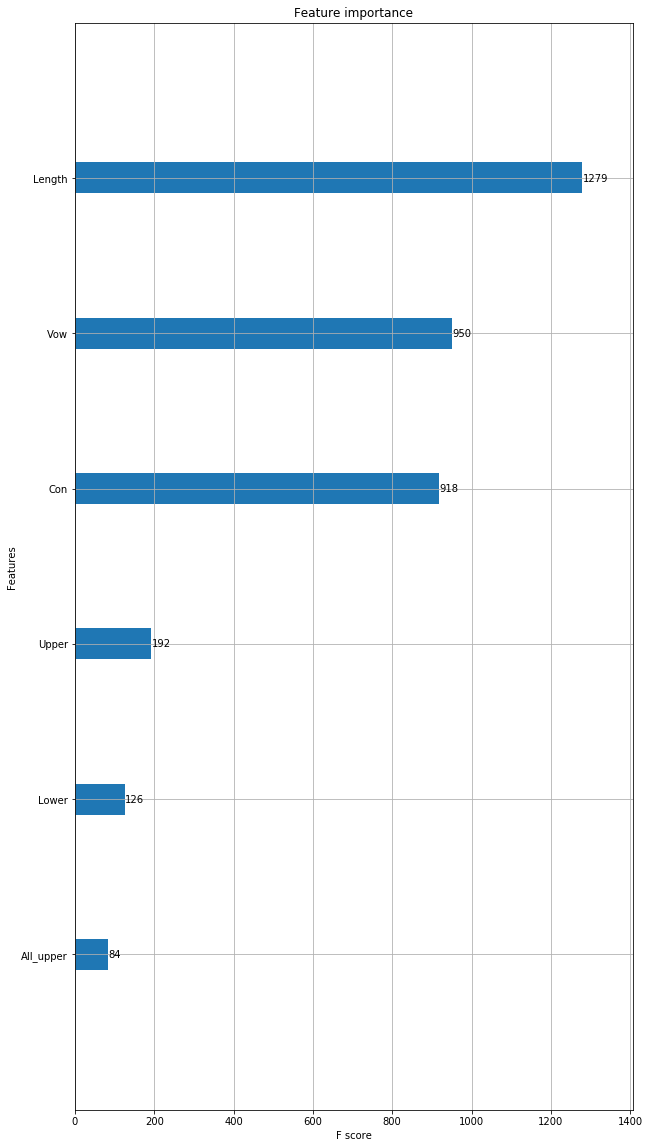

In [14]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
%matplotlib inline
my_plot_importance(model1, (10,20))
